#  **Machine Learning Assignment (AUEB 2023-2024)**  
## **3. Logistic regression classification**


---



*Yorgos Velissaridis P3210255*

*Evangelos Kleidopoulos P3190084*

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


Now for Logistic regression using the Stochastic Gradient Descent algorithm.

The general update rule for SGD is:

$$ \theta_{t+1} = \theta_t - \eta \nabla J(\theta_t; x^{(i)}, y^{(i)}) $$

And in the context of our implementation:

$\text{For each batch } (X_{\text{batch}}, y_{\text{batch}}):$

$$ \text{Forward Pass:} $$

$ \text{Compute logits: } z = X_{\text{batch}} \cdot \text{weights} $

$ \text{Compute probabilities using softmax: } \hat{y} = \text{softmax}(z) \text{ = }  \frac{\exp(z)}{\sum{\exp(z)}} $

$ \text{Compute cross-entropy loss: } J(\theta; X_{\text{batch}}, y_{\text{batch}}) = -\frac{1}{\text{batch size}} \sum_{i=1}^{\text{batch size}} \sum_{j=1}^{\text{num classes}} y_{\text{batch},j} \cdot \log(\hat{y}_{i,j}) $


$$ \text{Backward Pass:} $$


$ \text{Compute gradient: } \nabla J(\theta; X_{\text{batch}}, y_{\text{batch}}) = \frac{1}{\text{batch size}} X_{\text{batch}}^T \cdot (\hat{y} - y_{\text{batch}}) $

$ \text{Update weights using SGD:}  \text{ weights}_{next} = \text{weights} - \eta \cdot \nabla J(\theta; X_{\text{batch}}, y_{\text{batch}}) $

Where:
- $ \theta $ represents the model parameters (weights).
- $ \eta $ is the learning rate.

- $ \hat{y} $ is the predicted probabilities.

In [2]:
class LogisticRegression:

    def __init__(self, learning_rate=0.01, num_epochs=100, batch_size=100):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size

    # Converting logits into probabilities that sum up to 1 across all classes for each entry
    def softmax(self, x):
        exp_x = np.exp(x)
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def fit(self, X_train, y_train, X_val, y_val):
        num_features = X_train.shape[1]
        num_classes = len(np.unique(y_train))
        self.weights = np.zeros((num_features, num_classes))

        label_encoder = LabelEncoder()
        y_train_encoded = label_encoder.fit_transform(y_train)
        y_train_one_hot = np.eye(num_classes)[y_train_encoded]

        y_val_encoded = label_encoder.fit_transform(y_val)
        y_val_one_hot = np.eye(num_classes)[y_val_encoded]

        train_loss = []
        val_loss = []

        for epoch in range(self.num_epochs):
            # Shuffling the training data each epoch
            indices = np.arange(len(X_train))
            np.random.shuffle(indices)
            X_train_shuffled = X_train[indices]
            y_train_one_hot_shuffled = y_train_one_hot[indices]

            epoch_loss = 0
            batch_total = 0
            # Updating the model in mini-batches instead of all at once
            for i in range(0, len(X_train_shuffled), self.batch_size):
                batch_total+=1

                X_batch = X_train_shuffled[i:i + self.batch_size]
                y_batch = y_train_one_hot_shuffled[i:i + self.batch_size]

                # Forward pass
                logits = X_batch.dot(self.weights)
                probabilities = self.softmax(logits)

                # Compute the cross-entropy loss
                loss = -np.mean(np.sum(y_batch * np.log(probabilities), axis=1))
                epoch_loss += loss

                # Backward pass (compute gradients)
                gradient = X_batch.T.dot(probabilities - y_batch) / len(X_batch)

                # Update weights
                self.weights -= self.learning_rate * gradient

            # Save training loss
            avg_epoch_loss = epoch_loss / batch_total
            train_loss.append(avg_epoch_loss)

            # Evaluate on the validation set
            logits_val = X_val.dot(self.weights)
            probabilities_val = self.softmax(logits_val)
            val_loss.append(-np.mean(np.sum(y_val_one_hot * np.log(probabilities_val), axis=1)))


        return train_loss, val_loss

    def predict(self, X_test):
        logits_test = X_test.dot(self.weights)
        probabilities_test = self.softmax(logits_test)
        y_pred = np.argmax(probabilities_test, axis=1)
        return y_pred


We standardize our data, add a bias term and split them into train, test and validation sets.

We then train our model.

In [4]:
with open('GTzan_60features_5sec.csv', newline='') as csv_file:
    data = pd.read_csv(csv_file)

X = data.iloc[:, 2:62].values
y = data.iloc[:, 62].values

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Add a bias term to the features
X = np.c_[np.ones((X.shape[0], 1)), X]

# Split the data into training and testing and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

# Create and train the logistic regression model
logistic_regression = LogisticRegression(learning_rate = 0.02, num_epochs = 250, batch_size = 128)
train_loss, val_loss = logistic_regression.fit(X_train, y_train, X_val, y_val)

Here we plot the training and validation losses for each epoch.

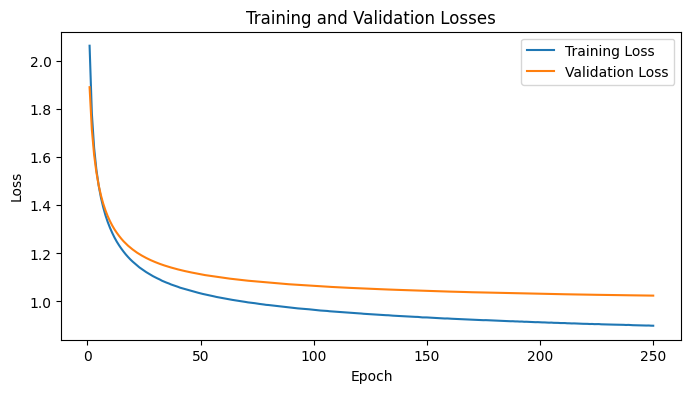

In [5]:
plt.figure(figsize=(8, 4))
# Plot Training Loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')

# Plot Validation Loss
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.legend()

plt.show()

Finally we test the model and see our model's accuracy and classificaation report using Sklearn.

In [6]:
# Make predictions on the test set
y_pred = logistic_regression.predict(X_test)
#Decode predicted labels
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Display classification report
class_report = classification_report(y_test, y_pred_decoded)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

       blues       0.68      0.64      0.66        59
   classical       0.83      0.91      0.87        66
     country       0.56      0.55      0.56        58
       disco       0.66      0.65      0.66        66
      hiphop       0.62      0.63      0.62        59
        jazz       0.52      0.50      0.51        46
       metal       0.76      0.76      0.76        55
         pop       0.77      0.84      0.80        55
      reggae       0.59      0.56      0.57        59
        rock       0.56      0.54      0.55        68

    accuracy                           0.66       591
   macro avg       0.66      0.66      0.66       591
weighted avg       0.66      0.66      0.66       591



Sklearn's implementation of SGD

In [7]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss="log_loss",max_iter=200)
clf.fit(X_train, y_train)
y_pred_sk = clf.predict(X_test)

class_report_sk = classification_report(y_test, y_pred_sk)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

       blues       0.68      0.64      0.66        59
   classical       0.83      0.91      0.87        66
     country       0.56      0.55      0.56        58
       disco       0.66      0.65      0.66        66
      hiphop       0.62      0.63      0.62        59
        jazz       0.52      0.50      0.51        46
       metal       0.76      0.76      0.76        55
         pop       0.77      0.84      0.80        55
      reggae       0.59      0.56      0.57        59
        rock       0.56      0.54      0.55        68

    accuracy                           0.66       591
   macro avg       0.66      0.66      0.66       591
weighted avg       0.66      0.66      0.66       591



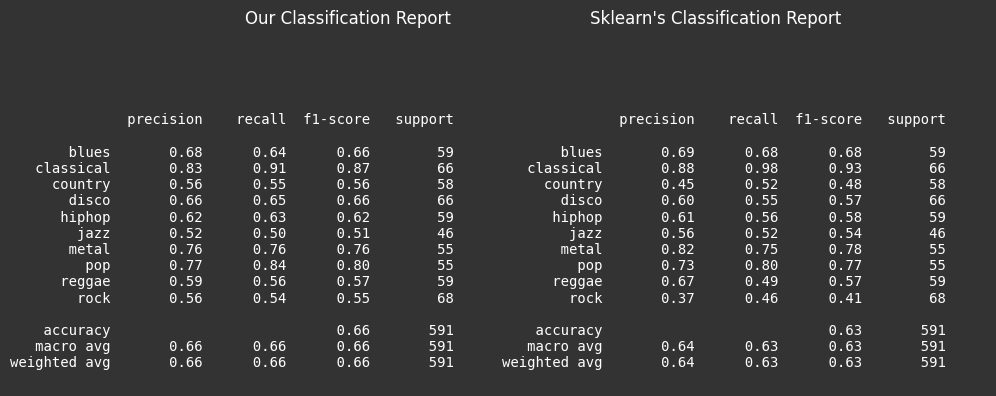

In [8]:
# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
fig.set_facecolor('#333333')
# Plot the first classification report
axs[0].text(0.1, 0.1, class_report, fontsize=10,color='white', verticalalignment='center', horizontalalignment='center', family='monospace')
axs[0].axis('off')
axs[0].set_title("Our Classification Report",color='white',horizontalalignment='center')

# Plot the second classification report
axs[1].text(0.1, 0.1, class_report_sk, fontsize=10,color='white', verticalalignment='center', horizontalalignment='center', family='monospace')
axs[1].axis('off')
axs[1].set_title("Sklearn's Classification Report",color='white',horizontalalignment='right')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()
